# Tensor
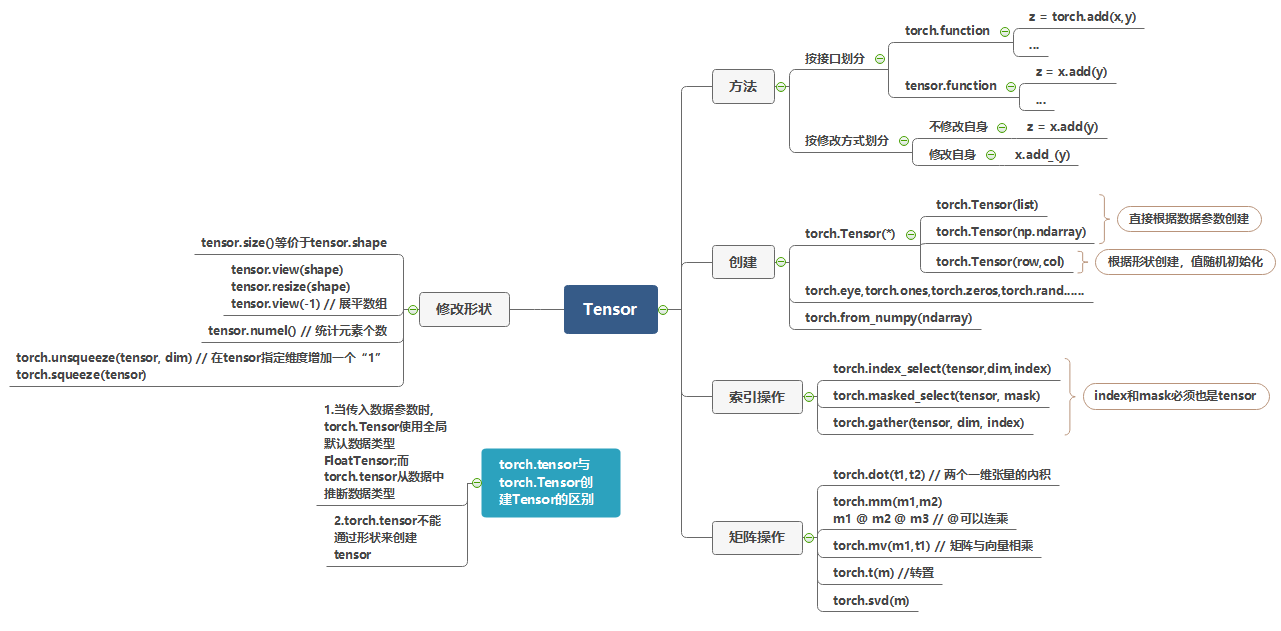

# 反向传播


## 标量反向传播

## 非标量反向传播